In [1]:
%reload_ext autoreload
%autoreload 2

# Simulate behavior using previous parameters

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from data_analysis import download_data, download_condition_counts, calc_condition_counts, ExperimentDataLoader
exp_data = ExperimentDataLoader(
    trialdata_file="rawtrialdata-anon.csv"
)

Participant participant_021:anonymized missing trials
Trial Indices = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]; expected [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
Participant participant_096:anonymized missing trials
Trial Indices = [0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]; expected [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


In [3]:
from itertools import product
from frozendict import frozendict
from tqdm.notebook import tqdm
from functools import lru_cache
from construal_shifting.task_modeling.participant_model import ParticipantModel
from construal_shifting.task_modeling.construal_trial_model import ConstrualTrialModel

In [4]:
import matplotlib
import matplotlib.pyplot as plt
font = {
    'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 12
}

matplotlib.rc('font', **font)

In [5]:
summary_df = pd.read_json('./data/summary_df.json')

In [6]:
exp_1_fit_params=dict(
    construal_cost_weight=1.70,
    construal_set_stickiness=5.33,
    action_random_choice=.09,
    construal_inverse_temp=1.0,
    action_inverse_temp=float('inf'),
)

In [7]:
from construal_shifting.task_modeling.participant_model import coarse_identifier, fine_identifier

In [8]:
from msdm.core.distributions import DictDistribution
from msdm.core.mdp import FunctionalPolicy, TabularPolicy
import random

In [9]:
import functools 
from construal_shifting.fastgridworld import GridWorld2 as GridWorld
from msdm.algorithms import PolicyIteration

@functools.lru_cache(maxsize=int(1e5))
def calculate_critical_notch_locs(tile_array):
    gw_params = dict(
        tile_array=tile_array,
        wall_features="ABCDEFG#",
        absorbing_features="$",
        initial_features="@",
        step_cost=-1,
    )
    gw_disc = GridWorld(
        **gw_params,
        discount_rate=1 - 1e-8
    )
    solvable = len(set(gw_disc.absorbing_states) & gw_disc.reachable_states()) > 0
    if not solvable:
        return set([])
    pi = PolicyIteration().plan_on(gw_disc)
    gw = GridWorld(**gw_params)
    try:
        occupancy = pi.policy.evaluate_on(gw).occupancy
    except AttributeError:
        occupancy = pi.policy.evaluate_on(gw).state_occupancy
    unavoidable_locs = {loc for loc, prob in occupancy.items() if prob == 1.0}
    notch_locs = set([])
    for f in 'abcdefg':
        if f in gw.feature_locations:
            notch_locs.update(gw.feature_locations[f])
    crit_notch_locs = notch_locs & unavoidable_locs
    crit_notch_locs = {(l['x'], l['y']) for l in crit_notch_locs}
    return crit_notch_locs

@functools.lru_cache(maxsize=int(1e5))
def calculate_alt_critical_notch_locs(tile_array):
    tile_array = np.array([list(r) for r in tile_array])
    pseudo_wall_idxs = [
        ((6, 6, 6, 6, 6, 6, 6, 6), (0, 1, 2, 4, 5, 6, 7, 8)),
        ((0, 1, 2, 4, 5, 6, 7, 8), (6, 6, 6, 6, 6, 6, 6, 6)),
        ((4, 5, 6, 7, 8, 10, 11, 12), (6, 6, 6, 6, 6, 6, 6, 6)),
        ((6, 6, 6, 6, 6, 6, 6, 6), (4, 5, 6, 7, 8, 10, 11, 12)),
        ((6, 6, 6), (0, 1, 2)),
        ((6, 6, 6, 6, 6), (4, 5, 6, 7, 8)),
        ((6, 6, 6), (10, 11, 12)),
        ((0, 1, 2), (6, 6, 6)),
        ((4, 5, 6, 7, 8), (6, 6, 6, 6, 6)),
        ((10, 11, 12), (6, 6, 6)),
    ]
    blocks_to_remove = [None, ] + [f for f in np.unique(tile_array) if f in "ABCDEFGHIJ"]
    for psudo_wall_idx, block_to_remove in product(pseudo_wall_idxs, blocks_to_remove):
        orig = tile_array[psudo_wall_idx]
        tile_array[psudo_wall_idx] = '#'
        if block_to_remove is not None:
            orig_blocks = tile_array == block_to_remove
            tile_array[tile_array == block_to_remove] = '.'
        pseudo_tile_array = tuple([''.join(r) for r in tile_array])
        critical_notch_locs = calculate_critical_notch_locs(pseudo_tile_array)
        tile_array[psudo_wall_idx] = orig
        if block_to_remove is not None:
            tile_array[np.where(orig_blocks)] = block_to_remove
        if len(critical_notch_locs) > 0:
            break
    assert len(critical_notch_locs) > 0
    return critical_notch_locs

def visited_critical_notch(traj, ctm):
    visited_locs = set(traj.state)
    tile_array = ctm.trial_params['tile_array']
    if 'fine' not in ctm.grid_name:
        critical_notch_locs = calculate_alt_critical_notch_locs(tuple(tile_array))
    else:
        critical_notch_locs = calculate_critical_notch_locs(tuple(tile_array))
    assert len(critical_notch_locs) > 0
    return len(visited_locs & critical_notch_locs) > 0

In [10]:
def simulate_participant_response(
    pmod,
    construal_cost_weight,
    construal_set_stickiness,
    construal_inverse_temp,
    action_inverse_temp,
    action_random_choice,
    seed,
):
    rng = random.Random(seed)
    ctms = []
    for test_trial in pmod.participant_data.test_trials():
        ctm = ConstrualTrialModel(**{
            **pmod.default_gw_params,
            **test_trial.invtransformed_GridWorld_params
        })
        ctm.grid_name = test_trial.grid_name
        ctms.append(ctm)

    cset_tfs = pmod.trials_set_nextset_probability(
        construal_set_stickiness=construal_set_stickiness,
        construal_cost_weight=construal_cost_weight,
        construal_inverse_temp=construal_inverse_temp,
    )
    cset_tfs = cset_tfs[-len(ctms):] # only take the test trials

    cset = 'fine'
    sim_stats = []
    for trial_i, (ctm, cset_tf) in enumerate(zip(ctms, cset_tfs)):
        # sample a construal set
        cset_tf = cset_tf[['coarse', 'fine'].index(cset)]
        cset = rng.choices(['coarse', 'fine'], weights=cset_tf)[0]
        
        # also get cset values
        coarse_val = ctm.construal_set_value(
            construal_prior=coarse_identifier,
            construal_cost_weight=construal_cost_weight,
            construal_inverse_temp=construal_inverse_temp,
        )
        fine_val = ctm.construal_set_value(
            construal_prior=fine_identifier,
            construal_cost_weight=construal_cost_weight,
            construal_inverse_temp=construal_inverse_temp,
        )

        # sample a construal and computed plan
        c_probs = ctm._construal_posterior(
            construal_cost_weight=construal_cost_weight,
            construal_inverse_temp=construal_inverse_temp,
            construal_prior={'fine': fine_identifier, 'coarse': coarse_identifier}[cset],
        )
        c_i = rng.choices(range(len(c_probs)), weights=c_probs)[0]
        computed_plans = ctm.epsilon_softmax_policies(
            action_inverse_temp=action_inverse_temp,
            action_random_choice=action_random_choice
        )
        cpolicy = TabularPolicy.from_state_action_lists(
            state_list=ctm.true_mdp.state_list,
            action_list=ctm.true_mdp.action_list,
            data=computed_plans[c_i]
        )

        # sample a trajectory and calculate notch visitation
        traj = cpolicy.run_on(ctm.true_mdp, rng=rng)
        visit_notch = any([ctm.true_mdp.feature_at(s.state) in 'abcdefg' for s in traj])
        visit_critical_notch = visited_critical_notch(traj, ctm)
        n_entities = ctm.cognitive_cost_vec[c_i]
        sim_stats.append(dict(
            construal_set=cset,
            prob_fine=cset_tf[1],
            fine_val=fine_val,
            coarse_val=coarse_val,
            n_entities=n_entities,
            cognitive_cost=n_entities*construal_cost_weight,
            trial=trial_i,
            visit_notch=visit_notch,
            visit_critical_notch=visit_critical_notch,
            sessionId=pmod.participant_data.sessionId,
            condition_name=pmod.participant_data.condition_name,
            seed=seed
        ))
    return sim_stats

In [11]:
rng = random.Random(15915)
runs = 20
psim_stats_rec = []
for pdata in tqdm(list(exp_data.completed_participant_data())):
    if pdata.sessionId not in summary_df.sessionId.values: # excluded participants
        continue
    pmod = ParticipantModel(pdata)
    for run_i in range(runs):
        sim_stats = simulate_participant_response(
            pmod,
            **exp_1_fit_params,
            seed=rng.randint(0, int(1e10))
        )
        psim_stats_rec.extend(sim_stats)
psim_stats = pd.DataFrame(psim_stats_rec)

In [15]:
psim_stats['cset_val_diff'] = psim_stats['coarse_val'] - psim_stats['fine_val']

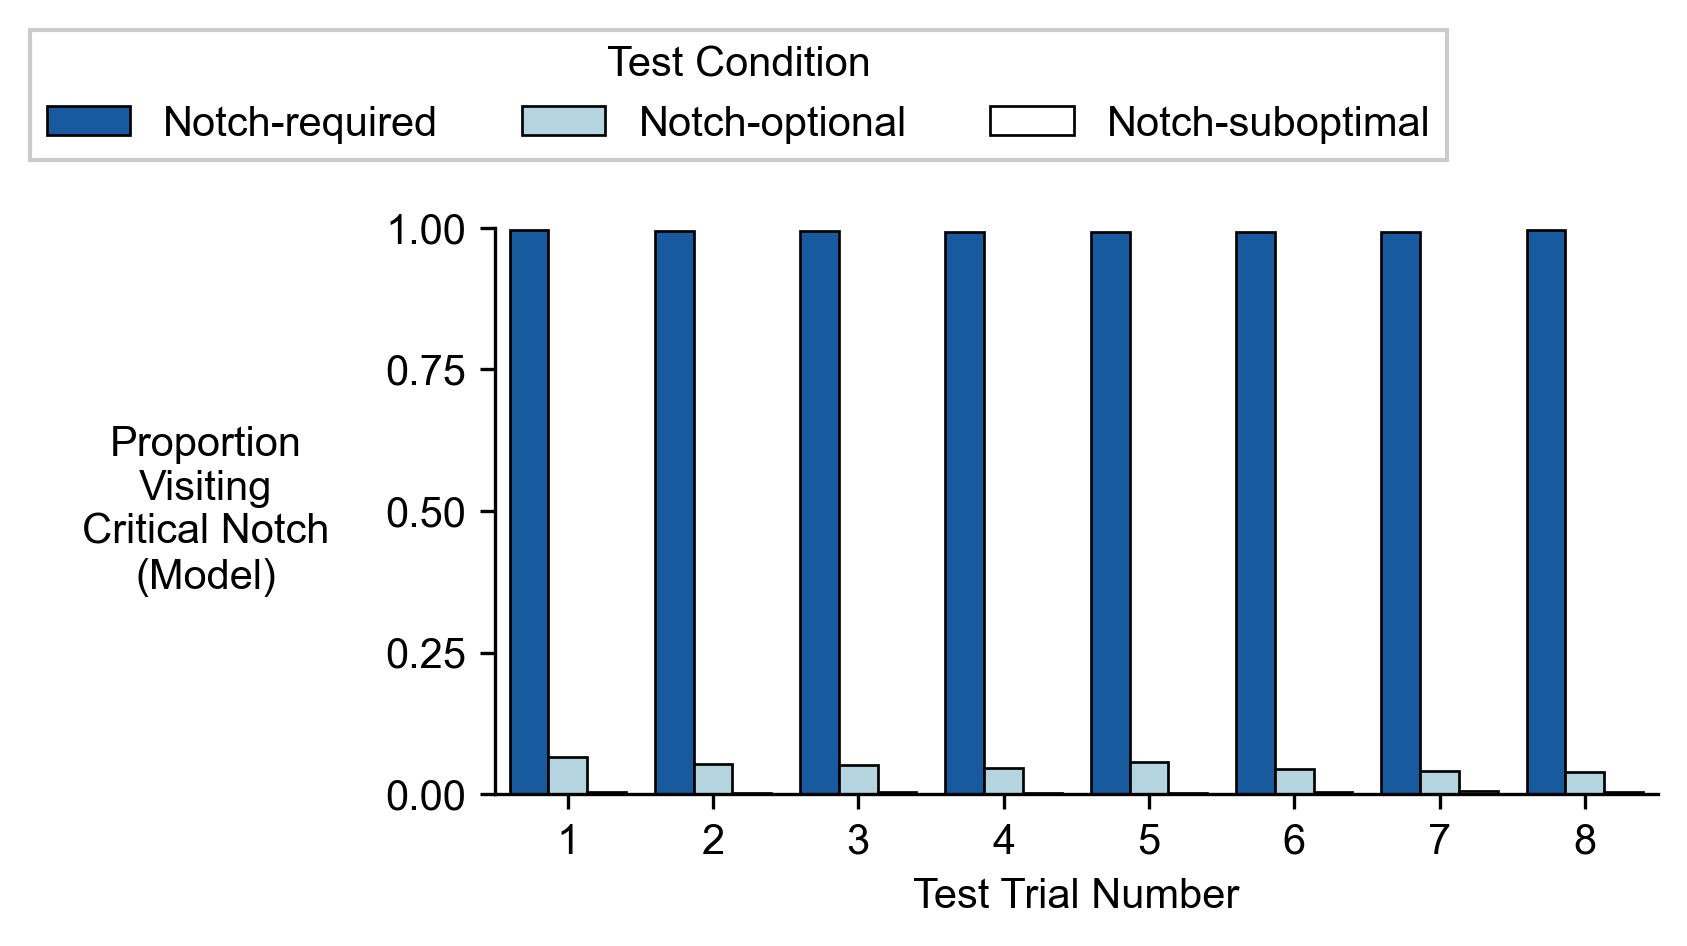

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5), dpi=300)
g = sns.barplot(
    ax=ax,
    data=psim_stats,
    x='trial',
    y='visit_critical_notch',
    hue='condition_name',
    hue_order=['ffffffffffff_ffffffff', 'ffffffffffff_bbbbbbbb', 'ffffffffffff_cccccccc'],
    palette=["#005AB5", "lightblue", "w"],
    ci=None,
    edgecolor='k',
    linewidth=.65,
    errwidth=1.,
    capsize=.15,
    errcolor='k'
)
g.set_ylim(0, 1.0)
g.set_yticks([0, .25, .5, .75, 1.0])
plt.legend(
    bbox_to_anchor=(-.4, 1.35),
    loc=2,
    borderaxespad=0.,
    fancybox=False,
    framealpha=1,
    ncol=3,
)
g.legend_.set_title("Test Condition")
for t, l in zip(g.legend_.texts, ["Notch-required", "Notch-optional", "Notch-suboptimal"]):
    t.set_text(l)
ax.set_ylabel("Proportion\nVisiting\nCritical Notch\n(Model)", rotation="horizontal", labelpad=43, va='center')
ax.set_xlabel("Test Trial Number")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
_ = ax.set_xticklabels(["1", "2", "3", "4", "5", '6', '7', '8'])

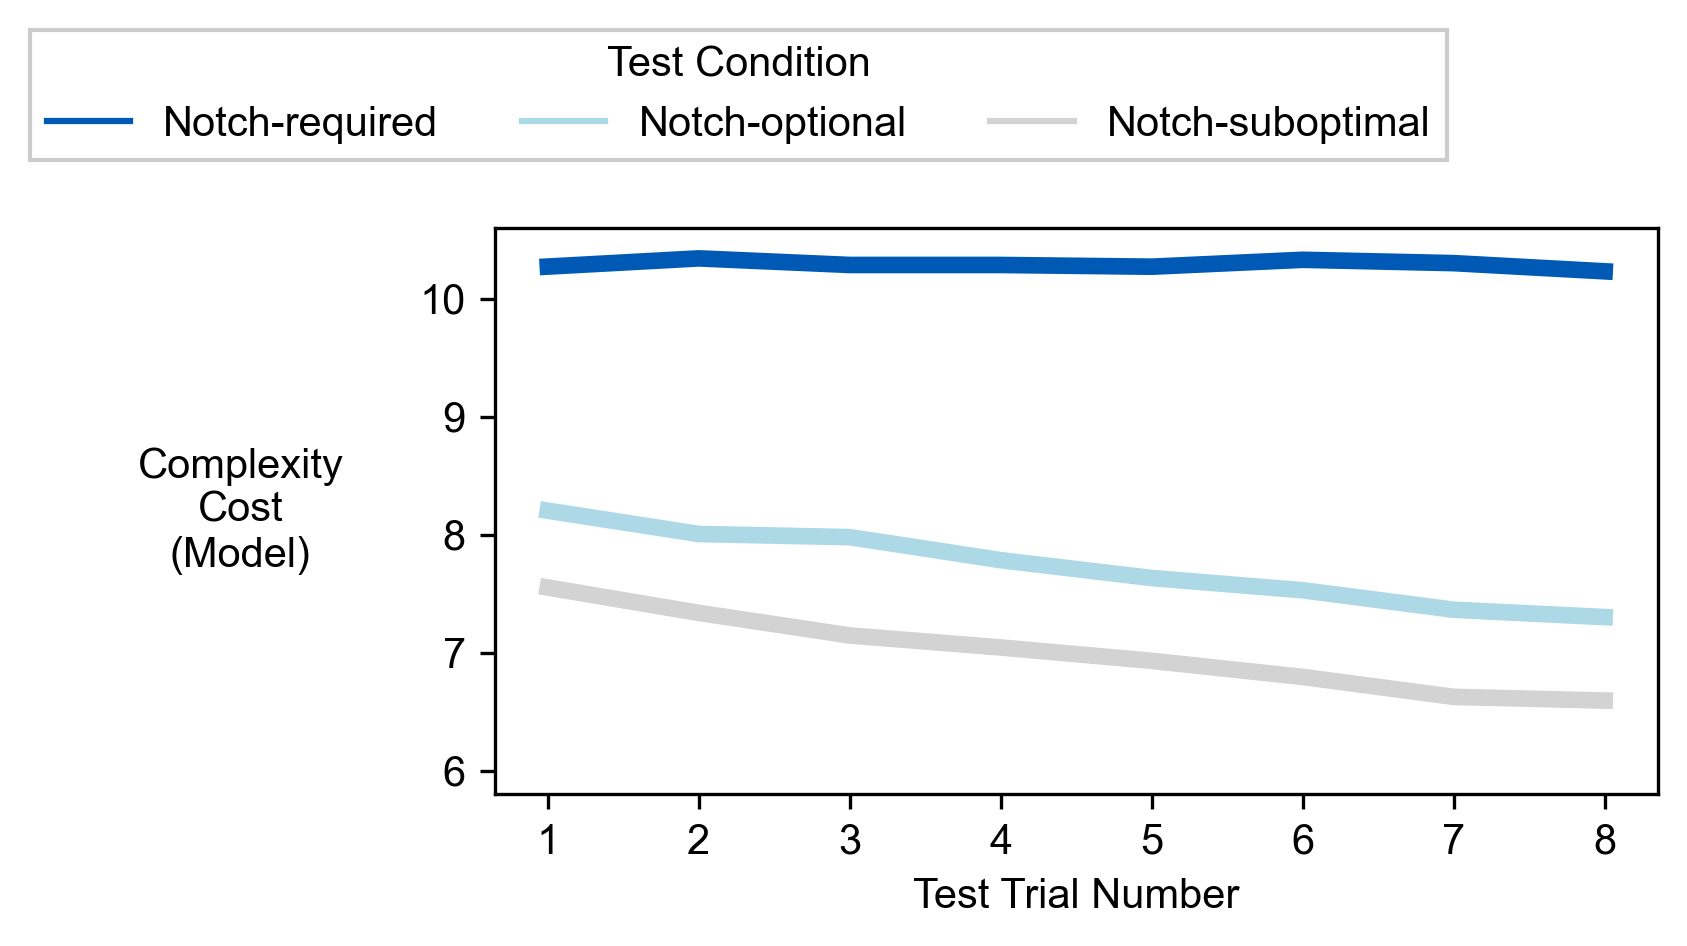

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5), dpi=300)
g = sns.lineplot(
    ax=ax,
    data=psim_stats,
    x='trial',
    y='cognitive_cost',
    hue='condition_name',
    # style="visited_critical_notch",
    hue_order=['ffffffffffff_ffffffff', 'ffffffffffff_bbbbbbbb', 'ffffffffffff_cccccccc'],
    palette=["#005AB5", "lightblue", "lightgrey"],
    err_style=None,
    lw=4,
)
plt.legend(
    bbox_to_anchor=(-.4, 1.35),
    loc=2,
    borderaxespad=0.,
    fancybox=False,
    framealpha=1,
    ncol=3,
    # fontsize=9,
    # title_fontsize=10
)
g.legend_.set_title("Test Condition")
for t, l in zip(g.legend_.texts, ["Notch-required", "Notch-optional", "Notch-suboptimal"]):
    t.set_text(l)
ax.set_xlabel("Test Trial Number")
ax.set_ylabel(
    "Complexity\nCost\n(Model)",
    rotation="horizontal",
    labelpad=43,
    va='center'
)
ax.set_ylim(5.8, 10.6)
ax.set_xticks(range(8))
_ = ax.set_xticklabels([str(i) for i in range(1,9)])